In [1]:
pip install gymnasium numpy matplotlib

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/f9/68/2bdc7b46b5f543dd865575f9d19716866bdb76e50dd33b71ed1a3dd8bb42/gymnasium-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for farama-notifications>=0.0.1 from https://files.pythonhosted.org/packages/05/2c/ffc08c54c05cdce6fbed2aeebc46348dbe180c6d2c541c7af7ba0aa5f5f8/Farama_Notifications-0.0.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 15.0 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


Initial Q-table shape: (16, 4)
Running 5 independent Q-learning experiments...
Running experiment 1/5...
Running experiment 2/5...
Running experiment 3/5...
Running experiment 4/5...
Running experiment 5/5...


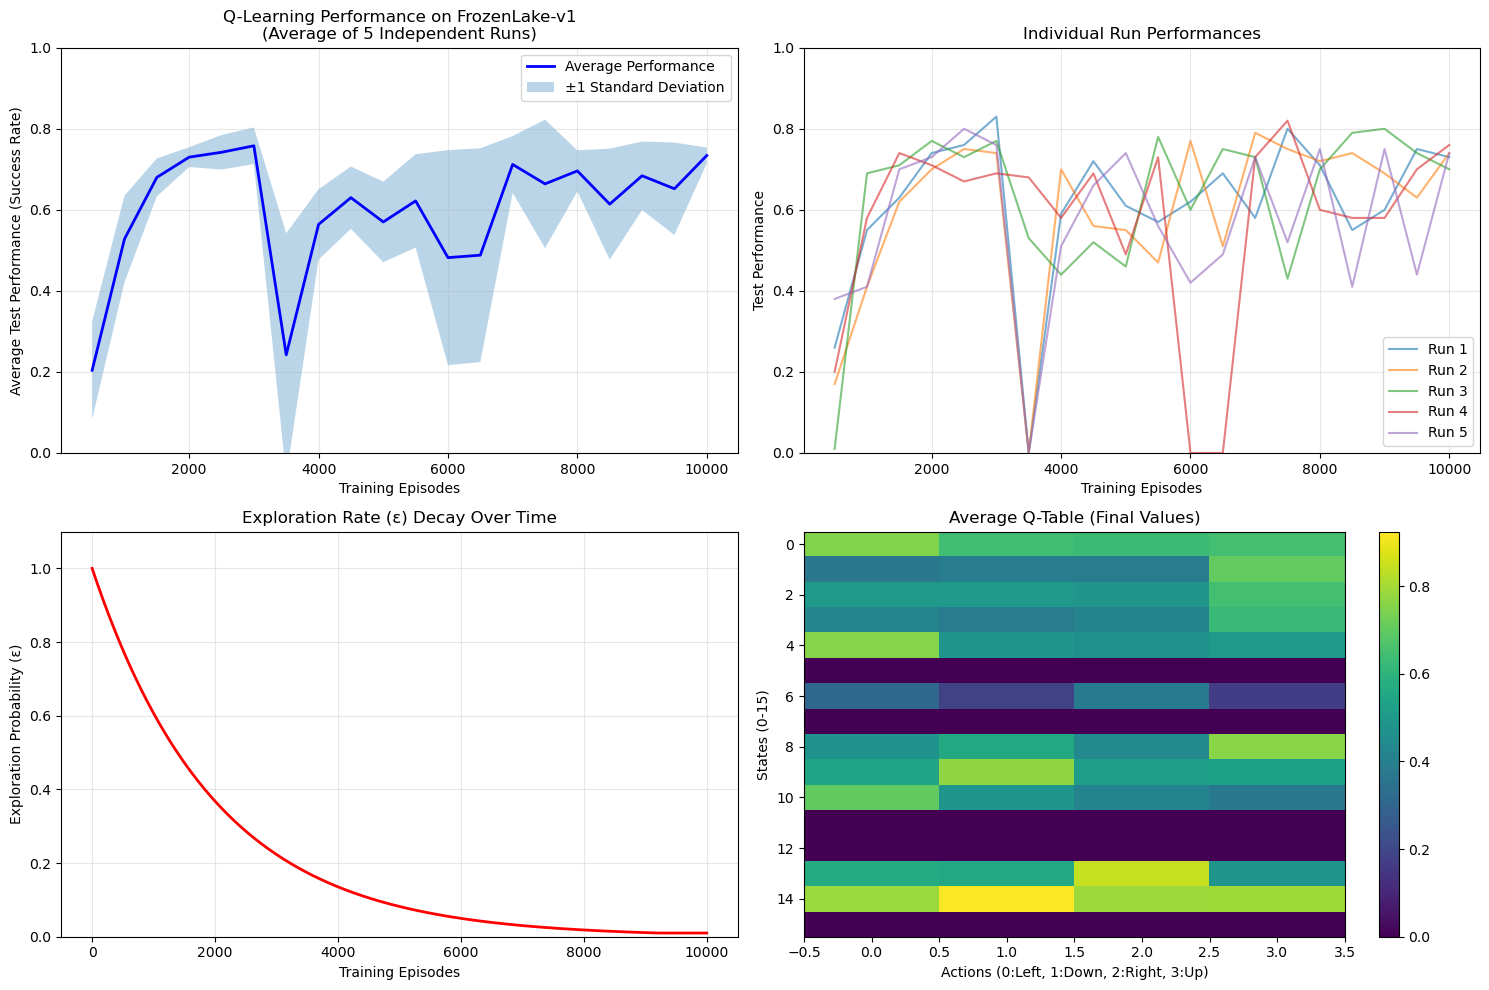


=== ASSIGNMENT RESULTS ===
Learning Rate (α): 0.1
Discount Factor (γ): 1.0
Training Episodes: 10000
Number of Independent Runs: 5

Final Performance: 0.734 ± 0.020
Final Success Rate: 73.4%

Performance Progression (every 1000 episodes):
Episode 1000: 0.204
Episode 2000: 0.528
Episode 3000: 0.680
Episode 4000: 0.730
Episode 5000: 0.742
Episode 6000: 0.758
Episode 7000: 0.242
Episode 8000: 0.564
Episode 9000: 0.630
Episode 10000: 0.570
Episode 11000: 0.622
Episode 12000: 0.482
Episode 13000: 0.488
Episode 14000: 0.712
Episode 15000: 0.664
Episode 16000: 0.696
Episode 17000: 0.614
Episode 18000: 0.684
Episode 19000: 0.652
Episode 20000: 0.734


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import defaultdict
import random

# Create environment - use stochastic version for realistic learning
env = gym.make("FrozenLake-v1", is_slippery=True)
n_observations = env.observation_space.n
n_actions = env.action_space.n

# Initialize the Q-table to 0
Q_table = np.zeros((n_observations, n_actions))
print("Initial Q-table shape:", Q_table.shape)

# Training parameters - Adjusted for better convergence
n_episodes = 10000
max_iter_episode = 100
exploration_proba = 1.0
exploration_decreasing_decay = 0.0005  # Slower decay for better exploration
min_exploration_proba = 0.01
gamma = 1.0   # Assignment specifies γ = 1.0  
lr = 0.1      # Assignment specifies α = 0.1

# Track rewards
rewards_per_episode = []

# Assignment requires 5 independent runs with different random seeds
def run_qlearning_experiment(seed=None):
    """Run a single Q-learning experiment"""
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    
    env = gym.make("FrozenLake-v1", is_slippery=True)
    if seed is not None:
        env.reset(seed=seed)
    
    Q_table = np.zeros((n_observations, n_actions))
    rewards_per_episode = []
    test_performance = []  # Store test performance every 500 episodes
    
    for e in range(n_episodes):
        current_state, _ = env.reset()
        done = False
        total_episode_reward = 0
        exploration_proba_current = max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e))
        
        for i in range(max_iter_episode): 
            if np.random.uniform(0, 1) < exploration_proba_current:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[current_state, :])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Q-learning update - correct formula
            if done and reward == 0:  # Fell in hole
                target = reward  # No future value for terminal states
            else:
                target = reward + gamma * np.max(Q_table[next_state, :])
            
            Q_table[current_state, action] = Q_table[current_state, action] + \
                                            lr * (target - Q_table[current_state, action])
            
            total_episode_reward += reward
            
            if done:
                break
            current_state = next_state
        
        rewards_per_episode.append(total_episode_reward)
        
        # Test performance every 500 episodes for learning curve (more frequent sampling)
        if (e + 1) % 500 == 0:
            test_rewards = []
            for _ in range(100):  # Test over 100 episodes
                test_state, _ = env.reset()
                test_total_reward = 0
                test_done = False
                
                for _ in range(max_iter_episode):
                    test_action = np.argmax(Q_table[test_state, :])  # Greedy policy
                    test_state, test_reward, test_terminated, test_truncated, _ = env.step(test_action)
                    test_total_reward += test_reward
                    test_done = test_terminated or test_truncated
                    if test_done:
                        break
                
                test_rewards.append(test_total_reward)
            
            test_performance.append(np.mean(test_rewards))
    
    env.close()
    return rewards_per_episode, test_performance, Q_table

# Run 5 independent experiments as required by assignment
print("Running 5 independent Q-learning experiments...")
all_training_rewards = []
all_test_performance = []
all_qtables = []

for run in range(5):
    print(f"Running experiment {run + 1}/5...")
    training_rewards, test_perf, qtable = run_qlearning_experiment(seed=42 + run)
    all_training_rewards.append(training_rewards)
    all_test_performance.append(test_perf)
    all_qtables.append(qtable)

# Calculate average performance across runs
avg_test_performance = np.mean(all_test_performance, axis=0)
std_test_performance = np.std(all_test_performance, axis=0)

# FIXED: Create episodes array that matches the test performance data
# Since we test every 500 episodes, we have 20 data points (500, 1000, 1500, ..., 10000)
episodes_for_curve = np.arange(500, n_episodes + 1, 500)

plt.figure(figsize=(15, 10))

# Main learning curve (average test performance)
plt.subplot(2, 2, 1)
plt.plot(episodes_for_curve, avg_test_performance, 'b-', linewidth=2, label='Average Performance')
plt.fill_between(episodes_for_curve, 
                 avg_test_performance - std_test_performance, 
                 avg_test_performance + std_test_performance, 
                 alpha=0.3, label='±1 Standard Deviation')
plt.title('Q-Learning Performance on FrozenLake-v1\n(Average of 5 Independent Runs)')
plt.xlabel('Training Episodes')
plt.ylabel('Average Test Performance (Success Rate)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Individual run performances
plt.subplot(2, 2, 2)
for i in range(5):
    plt.plot(episodes_for_curve, all_test_performance[i], alpha=0.6, label=f'Run {i+1}')
plt.title('Individual Run Performances')
plt.xlabel('Training Episodes')
plt.ylabel('Test Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Exploration decay curve
exploration_curve = [max(min_exploration_proba, np.exp(-exploration_decreasing_decay * e)) for e in range(n_episodes)]
plt.subplot(2, 2, 3)
plt.plot(exploration_curve, 'r-', linewidth=2)
plt.title('Exploration Rate (ε) Decay Over Time')
plt.xlabel('Training Episodes')
plt.ylabel('Exploration Probability (ε)')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.1)

# Final Q-table visualization (average across runs)
avg_qtable = np.mean(all_qtables, axis=0)
plt.subplot(2, 2, 4)
im = plt.imshow(avg_qtable, cmap='viridis', aspect='auto')
plt.title('Average Q-Table (Final Values)')
plt.xlabel('Actions (0:Left, 1:Down, 2:Right, 3:Up)')
plt.ylabel('States (0-15)')
plt.colorbar(im)

plt.tight_layout()
plt.show()

# Performance analysis
final_performance = avg_test_performance[-1]
final_std = std_test_performance[-1]

print(f"\n=== ASSIGNMENT RESULTS ===")
print(f"Learning Rate (α): {lr}")
print(f"Discount Factor (γ): {gamma}")
print(f"Training Episodes: {n_episodes}")
print(f"Number of Independent Runs: 5")
print(f"\nFinal Performance: {final_performance:.3f} ± {final_std:.3f}")
print(f"Final Success Rate: {final_performance:.1%}")

# Performance progression analysis
print(f"\nPerformance Progression (every 1000 episodes):")
for i in range(len(avg_test_performance)):
    episode = (i + 1) * 1000
    perf = avg_test_performance[i]
    print(f"Episode {episode:4d}: {perf:.3f}")

# Create environment for final analysis
env = gym.make("FrozenLake-v1", is_slippery=True)
